<a href="https://colab.research.google.com/github/vincentyang1998/eventstudy.github.io/blob/main/2013_2014_Event_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0 Setup and clean data

In [58]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm, t
import seaborn as sns
import statsmodels.api as sm
import datetime
from textwrap import wrap

In [111]:
df1 = pd.read_csv('SP500_2013_2014_csv.zip',compression='zip',parse_dates=True)
df1.info()

<ipython-input-111-61687ccf6b6a>:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('SP500_2013_2014_csv.zip',compression='zip',parse_dates=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2727482 entries, 0 to 2727481
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   ticker            object 
 2   cusip             object 
 3   ret               float64
 4   vwretd            float64
 5   meanest           float64
 6   actual            float64
 7   announcementDate  object 
 8   group_id          int64  
dtypes: float64(4), int64(1), object(4)
memory usage: 187.3+ MB


In [112]:
df1['date'] =  pd.to_datetime(df1['date'], format='%d%b%Y')
df1['announcementDate'] =  pd.to_datetime(df1['announcementDate'], format='%d%b%Y')
df1.head()

,date,ticker,cusip,ret,vwretd,meanest,actual,announcementDate,group_id
0,2012-10-01,ADT,00101J10,NaN,0.002808,0.42,0.41,2013-05-01,1
1,2012-10-02,ADT,00101J10,0.028441,0.001179,0.42,0.41,2013-05-01,1
2,2012-10-03,ADT,00101J10,0.019828,0.002520,0.42,0.41,2013-05-01,1
3,2012-10-04,ADT,00101J10,-0.013303,0.007665,0.42,0.41,2013-05-01,1
4,2012-10-05,ADT,00101J10,-0.008556,-0.000143,0.42,0.41,2013-05-01,1


In [96]:
No_firms = df1['ticker'].nunique()
No_firms

488

#1 Set the event window and screen Good/Bad news

In [117]:
#Define Good News/ Bad News /No News
df3 = df1.copy()
conditions = [(((df3['actual'] - df3['meanest'])/df3['meanest'])>0.025),
 (((df3['meanest'] - df3['actual'])/df3['meanest'])>0.025),
  (abs((df3['meanest'] - df3['actual'])/df3['meanest'])<=0.025)]
values = ['Good_News', 'Bad_News', 'No_News']
df3['New_information'] = np.select(conditions, values)
df3['Event_day'] = df3['date'] - df3['announcementDate']
df3.head()

,date,ticker,cusip,ret,vwretd,meanest,actual,announcementDate,group_id,New_information,Event_day
0,2012-10-01,ADT,00101J10,NaN,0.002808,0.42,0.41,2013-05-01,1,No_News,-212 days
1,2012-10-02,ADT,00101J10,0.028441,0.001179,0.42,0.41,2013-05-01,1,No_News,-211 days
2,2012-10-03,ADT,00101J10,0.019828,0.002520,0.42,0.41,2013-05-01,1,No_News,-210 days
3,2012-10-04,ADT,00101J10,-0.013303,0.007665,0.42,0.41,2013-05-01,1,No_News,-209 days
4,2012-10-05,ADT,00101J10,-0.008556,-0.000143,0.42,0.41,2013-05-01,1,No_News,-208 days


In [116]:
# Calculate the event window in the interval [20 trading days before the announcement date; 20 trading days after the announcement date] for each firm-announcement date.
df2 = df3.copy()
conditions = [(df2['date'] > (df2['announcementDate']+ datetime.timedelta(days=20))),
 (df2['date'] < (df2['announcementDate']- datetime.timedelta(days=20))),
  (df2['date'] <= (df2['announcementDate']+ datetime.timedelta(days=20))) & (df2['date'] >= (df2['announcementDate']- datetime.timedelta(days=20)))]
values = [0, 0, 1] # 1 meaning the rows in the event window
df2['check_event_window'] = np.select(conditions, values)
event_window = df2[df2['check_event_window'] == 1]
event_window.tail()

,date,ticker,cusip,ret,vwretd,meanest,actual,announcementDate,group_id,New_information,Event_day,check_event_window
2727472,2014-12-17,AVGO,Y0486S10,0.020651,0.021779,1.68,1.99,2014-12-03,4426,Good_News,14 days,1
2727473,2014-12-18,AVGO,Y0486S10,0.026871,0.021536,1.68,1.99,2014-12-03,4426,Good_News,15 days,1
2727474,2014-12-19,AVGO,Y0486S10,-0.014757,0.004598,1.68,1.99,2014-12-03,4426,Good_News,16 days,1
2727475,2014-12-22,AVGO,Y0486S10,0.012581,0.003256,1.68,1.99,2014-12-03,4426,Good_News,19 days,1
2727476,2014-12-23,AVGO,Y0486S10,-0.006212,0.002200,1.68,1.99,2014-12-03,4426,Good_News,20 days,1


#2 Set the estimation window

In [107]:
df4 = df1.copy()
conditions = [(df4['date'] >= (df4['announcementDate']- datetime.timedelta(days=20))),
 (df4['date'] < (df4['announcementDate']- datetime.timedelta(days=270))),
  (df4['date'] < (df4['announcementDate']- datetime.timedelta(days=20))) & (df4['date'] >= (df4['announcementDate']- datetime.timedelta(days=270)))]
values = [0, 0, 1] # 1 meaning the rows in the estimation window
df4['check_estimation_window'] = np.select(conditions, values)
df4.head()

,date,ticker,cusip,ret,vwretd,meanest,actual,announcementDate,group_id,check_estimation_window
0,2012-10-01,ADT,00101J10,NaN,0.002808,0.42,0.41,2013-05-01,1,1
1,2012-10-02,ADT,00101J10,0.028441,0.001179,0.42,0.41,2013-05-01,1,1
2,2012-10-03,ADT,00101J10,0.019828,0.002520,0.42,0.41,2013-05-01,1,1
3,2012-10-04,ADT,00101J10,-0.013303,0.007665,0.42,0.41,2013-05-01,1,1
4,2012-10-05,ADT,00101J10,-0.008556,-0.000143,0.42,0.41,2013-05-01,1,1
...,...,...,...,...,...,...,...,...,...,...
2727477,2014-12-24,AVGO,Y0486S10,-0.000595,0.000586,1.68,1.99,2014-12-03,4426,0
2727478,2014-12-26,AVGO,Y0486S10,-0.000993,0.003668,1.68,1.99,2014-12-03,4426,0
2727479,2014-12-29,AVGO,Y0486S10,0.006659,0.001236,1.68,1.99,2014-12-03,4426,0
2727480,2014-12-30,AVGO,Y0486S10,-0.004344,-0.004281,1.68,1.99,2014-12-03,4426,0


In [118]:
# Calculate the estimation window in the interval [270 trading days before the announcement date; 20 trading days before the announcement date) for each firm-announcement date.
estimation_window_0 = df4[df4['check_estimation_window'] == 1]
estimation_window_0

,date,ticker,cusip,ret,vwretd,meanest,actual,announcementDate,group_id,check_estimation_window
0,2012-10-01,ADT,00101J10,NaN,0.002808,0.42,0.41,2013-05-01,1,1
1,2012-10-02,ADT,00101J10,0.028441,0.001179,0.42,0.41,2013-05-01,1,1
2,2012-10-03,ADT,00101J10,0.019828,0.002520,0.42,0.41,2013-05-01,1,1
3,2012-10-04,ADT,00101J10,-0.013303,0.007665,0.42,0.41,2013-05-01,1,1
4,2012-10-05,ADT,00101J10,-0.008556,-0.000143,0.42,0.41,2013-05-01,1,1
...,...,...,...,...,...,...,...,...,...,...
2727444,2014-11-06,AVGO,Y0486S10,0.010610,0.003804,1.68,1.99,2014-12-03,4426,1
2727445,2014-11-07,AVGO,Y0486S10,-0.029556,0.001992,1.68,1.99,2014-12-03,4426,1
2727446,2014-11-10,AVGO,Y0486S10,0.010231,0.002730,1.68,1.99,2014-12-03,4426,1
2727447,2014-11-11,AVGO,Y0486S10,0.002910,0.001133,1.68,1.99,2014-12-03,4426,1


#3 Screen Good/ Bad/ No news

In [ ]:
Different_type_events = event_window.copy()
Good_news_events = Different_type_events[Different_type_events['New_information'] =='Good_News']
No_news_events = Different_type_events[Different_type_events['New_information'] =='No_News']
Bad_news_events = Different_type_events[Different_type_events['New_information'] =='Bad_News']

In [ ]:
No_Event_Table = {'Good_News':pd.Series([Good_news_events['group_id'].nunique()],index=['No.']),
         'No_News':pd.Series([No_news_events['group_id'].nunique()],index=['No.']),
         'Bad_News':pd.Series([Bad_news_events['group_id'].nunique()],index=['No.']),
         'Total':pd.Series([Good_news_events['group_id'].nunique()+No_news_events['group_id'].nunique()+Bad_news_events['group_id'].nunique()],index=['No.'])}
No_Event_Table = pd.DataFrame(No_Event_Table)
No_Event_Table # Based on this result, I make Table 1.

#4 Models for Measuring Normal Performance

##4.1 Calculate Normal Return on Constant Mean Return Model

In [119]:
estimation_window = estimation_window_0.copy()
estimation_window.dropna(subset=['ret'], inplace=True)
estimation_window_1 = estimation_window.copy()
estimation_window_1['intercept'] = 1
estimation_window_1

,date,ticker,cusip,ret,vwretd,meanest,actual,announcementDate,group_id,check_estimation_window,intercept
1,2012-10-02,ADT,00101J10,0.028441,0.001179,0.42,0.41,2013-05-01,1,1,1
2,2012-10-03,ADT,00101J10,0.019828,0.002520,0.42,0.41,2013-05-01,1,1,1
3,2012-10-04,ADT,00101J10,-0.013303,0.007665,0.42,0.41,2013-05-01,1,1,1
4,2012-10-05,ADT,00101J10,-0.008556,-0.000143,0.42,0.41,2013-05-01,1,1,1
5,2012-10-08,ADT,00101J10,-0.000262,-0.003573,0.42,0.41,2013-05-01,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2727444,2014-11-06,AVGO,Y0486S10,0.010610,0.003804,1.68,1.99,2014-12-03,4426,1,1
2727445,2014-11-07,AVGO,Y0486S10,-0.029556,0.001992,1.68,1.99,2014-12-03,4426,1,1
2727446,2014-11-10,AVGO,Y0486S10,0.010231,0.002730,1.68,1.99,2014-12-03,4426,1,1
2727447,2014-11-11,AVGO,Y0486S10,0.002910,0.001133,1.68,1.99,2014-12-03,4426,1,1


In [140]:
# Run the regession for constant mean return to find alpha based on the estimation window data
def mean_return_model(estimation_window_1, ret, constant_mean):
    Y = estimation_window_1['ret']
    X = estimation_window_1['intercept']
    result = sm.OLS(Y, X).fit()
    return result.params
mean_return_param = estimation_window_1.groupby('group_id').apply(mean_return_model, 'Y', ['X'])
mean_return_param.tail()

,intercept
group_id,
4410,0.000205
4411,0.001577
4422,0.003588
4423,0.002834
4426,0.002157


In [121]:
# Compute the normal return in the event window according to the constant mean return model
event_window_2 = event_window.copy()
mean_return_data = event_window_2.merge(mean_return_param, left_on=['group_id'], right_on = ['group_id'], how = 'left')
mean_return_data['normal_return'] = mean_return_data['intercept']
mean_return_data

,date,ticker,cusip,ret,vwretd,meanest,actual,announcementDate,group_id,New_information,Event_day,check_event_window,intercept,normal_return
0,2013-04-11,ADT,00101J10,-0.011840,0.003194,0.42,0.41,2013-05-01,1,No_News,-20 days,1,0.001731,0.001731
1,2013-04-12,ADT,00101J10,0.020191,-0.003765,0.42,0.41,2013-05-01,1,No_News,-19 days,1,0.001731,0.001731
2,2013-04-15,ADT,00101J10,-0.042627,-0.025563,0.42,0.41,2013-05-01,1,No_News,-16 days,1,0.001731,0.001731
3,2013-04-16,ADT,00101J10,-0.014312,0.014659,0.42,0.41,2013-05-01,1,No_News,-15 days,1,0.001731,0.001731
4,2013-04-17,ADT,00101J10,0.012445,-0.014664,0.42,0.41,2013-05-01,1,No_News,-14 days,1,0.001731,0.001731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102847,2014-12-17,AVGO,Y0486S10,0.020651,0.021779,1.68,1.99,2014-12-03,4426,Good_News,14 days,1,0.002157,0.002157
102848,2014-12-18,AVGO,Y0486S10,0.026871,0.021536,1.68,1.99,2014-12-03,4426,Good_News,15 days,1,0.002157,0.002157
102849,2014-12-19,AVGO,Y0486S10,-0.014757,0.004598,1.68,1.99,2014-12-03,4426,Good_News,16 days,1,0.002157,0.002157
102850,2014-12-22,AVGO,Y0486S10,0.012581,0.003256,1.68,1.99,2014-12-03,4426,Good_News,19 days,1,0.002157,0.002157


## 4.2 Calculate Normal Return on Market Model

In [122]:
# Run the regession for market mean return to find alpha and beta based on the estimation window data
def market_model(estimation_window_1, ret, vwretd):
    Y = estimation_window_1['ret']
    X = estimation_window_1[['intercept','vwretd']]
    result = sm.OLS(Y, X).fit()
    return result.params
market_return_param = estimation_window_1.groupby('group_id').apply(market_model, 'Y', ['X'])
market_return_param = market_return_param.rename(columns={'vwretd': 'beta_i'})
market_return_param.head()

,intercept,beta_i
group_id,,
1,0.001202,0.630141
2,-0.001705,0.823178
3,-0.001847,0.850697
4,-0.000582,0.845246
5,0.000263,1.243095


In [123]:
# Compute the normal return in the event window according to the alpha and beta finding from market model
market_return_data = event_window_2.merge(market_return_param, left_on=['group_id'], right_on = ['group_id'], how = 'left')
market_return_data['normal_return'] = market_return_data['intercept'] + market_return_data['beta_i']*market_return_data['vwretd']
market_return_data

,date,ticker,cusip,ret,vwretd,meanest,actual,announcementDate,group_id,New_information,Event_day,check_event_window,intercept,beta_i,normal_return
0,2013-04-11,ADT,00101J10,-0.011840,0.003194,0.42,0.41,2013-05-01,1,No_News,-20 days,1,0.001202,0.630141,0.003214
1,2013-04-12,ADT,00101J10,0.020191,-0.003765,0.42,0.41,2013-05-01,1,No_News,-19 days,1,0.001202,0.630141,-0.001171
2,2013-04-15,ADT,00101J10,-0.042627,-0.025563,0.42,0.41,2013-05-01,1,No_News,-16 days,1,0.001202,0.630141,-0.014907
3,2013-04-16,ADT,00101J10,-0.014312,0.014659,0.42,0.41,2013-05-01,1,No_News,-15 days,1,0.001202,0.630141,0.010439
4,2013-04-17,ADT,00101J10,0.012445,-0.014664,0.42,0.41,2013-05-01,1,No_News,-14 days,1,0.001202,0.630141,-0.008039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102847,2014-12-17,AVGO,Y0486S10,0.020651,0.021779,1.68,1.99,2014-12-03,4426,Good_News,14 days,1,0.001381,1.886889,0.042476
102848,2014-12-18,AVGO,Y0486S10,0.026871,0.021536,1.68,1.99,2014-12-03,4426,Good_News,15 days,1,0.001381,1.886889,0.042018
102849,2014-12-19,AVGO,Y0486S10,-0.014757,0.004598,1.68,1.99,2014-12-03,4426,Good_News,16 days,1,0.001381,1.886889,0.010057
102850,2014-12-22,AVGO,Y0486S10,0.012581,0.003256,1.68,1.99,2014-12-03,4426,Good_News,19 days,1,0.001381,1.886889,0.007524


#5 CAR'S for the Earnings Announcement Example

## 5.1 Based on Market Model

In [124]:
market_return_data['abnormal_return'] = (market_return_data['ret'] - market_return_data['normal_return'])
market_return_data['Event_day']= (market_return_data['Event_day']).dt.days
market_return_data

,date,ticker,cusip,ret,vwretd,meanest,actual,announcementDate,group_id,New_information,Event_day,check_event_window,intercept,beta_i,normal_return,abnormal_return
0,2013-04-11,ADT,00101J10,-0.011840,0.003194,0.42,0.41,2013-05-01,1,No_News,-20,1,0.001202,0.630141,0.003214,-0.015054
1,2013-04-12,ADT,00101J10,0.020191,-0.003765,0.42,0.41,2013-05-01,1,No_News,-19,1,0.001202,0.630141,-0.001171,0.021361
2,2013-04-15,ADT,00101J10,-0.042627,-0.025563,0.42,0.41,2013-05-01,1,No_News,-16,1,0.001202,0.630141,-0.014907,-0.027721
3,2013-04-16,ADT,00101J10,-0.014312,0.014659,0.42,0.41,2013-05-01,1,No_News,-15,1,0.001202,0.630141,0.010439,-0.024751
4,2013-04-17,ADT,00101J10,0.012445,-0.014664,0.42,0.41,2013-05-01,1,No_News,-14,1,0.001202,0.630141,-0.008039,0.020484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102847,2014-12-17,AVGO,Y0486S10,0.020651,0.021779,1.68,1.99,2014-12-03,4426,Good_News,14,1,0.001381,1.886889,0.042476,-0.021825
102848,2014-12-18,AVGO,Y0486S10,0.026871,0.021536,1.68,1.99,2014-12-03,4426,Good_News,15,1,0.001381,1.886889,0.042018,-0.015146
102849,2014-12-19,AVGO,Y0486S10,-0.014757,0.004598,1.68,1.99,2014-12-03,4426,Good_News,16,1,0.001381,1.886889,0.010057,-0.024813
102850,2014-12-22,AVGO,Y0486S10,0.012581,0.003256,1.68,1.99,2014-12-03,4426,Good_News,19,1,0.001381,1.886889,0.007524,0.005057


In [125]:
Good_News_market_data = market_return_data[mean_return_data['New_information'] == 'Good_News']
AR_Good_News_market_model = Good_News_market_data.groupby('Event_day')['abnormal_return'].mean()
Sub_Table_1_1 = pd.DataFrame(AR_Good_News_market_model)
Sub_Table_1_1 = Sub_Table_1_1.rename(columns={'abnormal_return': 'Good_News_AR'})
Sub_Table_1_1['Good_News_CAR'] = Sub_Table_1_1['Good_News_AR'].cumsum()
Sub_Table_1_1

,Good_News_AR,Good_News_CAR
Event_day,,
-20,0.000107,0.000107
-19,0.000028,0.000135
-18,0.001002,0.001137
-17,-0.000794,0.000343
-16,0.000611,0.000954
-15,0.000102,0.001056
-14,0.000649,0.001704
-13,0.000809,0.002514
-12,0.000247,0.002760


In [126]:
No_News_market_data = market_return_data[market_return_data['New_information'] == 'No_News']
AR_No_News_market_model = No_News_market_data.groupby('Event_day')['abnormal_return'].mean()
Sub_Table_1_2 = pd.DataFrame(AR_No_News_market_model)
Sub_Table_1_2 = Sub_Table_1_2.rename(columns={'abnormal_return': 'No_News_AR'})
Sub_Table_1_2['No_News_CAR'] = Sub_Table_1_2['No_News_AR'].cumsum()
Sub_Table_1_2

,No_News_AR,No_News_CAR
Event_day,,
-20,6.375262e-04,0.000638
-19,-3.403541e-04,0.000297
-18,4.677998e-04,0.000765
-17,7.386913e-04,0.001504
-16,1.620509e-04,0.001666
-15,6.832550e-05,0.001734
-14,2.771847e-04,0.002011
-13,3.252965e-04,0.002337
-12,7.801280e-05,0.002415


In [127]:
Bad_News_market_data = market_return_data[market_return_data['New_information'] == 'Bad_News']
AR_Bad_News_market_model = Bad_News_market_data.groupby('Event_day')['abnormal_return'].mean()
Sub_Table_1_3 = pd.DataFrame(AR_Bad_News_market_model)
Sub_Table_1_3 = Sub_Table_1_3.rename(columns={'abnormal_return': 'Bad_News_AR'})
Sub_Table_1_3['Bad_News_CAR'] = Sub_Table_1_3['Bad_News_AR'].cumsum()
Sub_Table_1_3

,Bad_News_AR,Bad_News_CAR
Event_day,,
-20,-0.000092,-0.000092
-19,-0.001164,-0.001256
-18,-0.000686,-0.001942
-17,-0.001333,-0.003275
-16,-0.000849,-0.004124
-15,-0.000445,-0.004569
-14,0.000114,-0.004455
-13,-0.000181,-0.004636
-12,0.001099,-0.003537


In [128]:
Table_1_Parta = pd.concat([Sub_Table_1_1, Sub_Table_1_2,Sub_Table_1_3],axis=1,sort=False)
Table_1_Parta

,Good_News_AR,Good_News_CAR,No_News_AR,No_News_CAR,Bad_News_AR,Bad_News_CAR
Event_day,,,,,,
-20,0.000107,0.000107,6.375262e-04,0.000638,-0.000092,-0.000092
-19,0.000028,0.000135,-3.403541e-04,0.000297,-0.001164,-0.001256
-18,0.001002,0.001137,4.677998e-04,0.000765,-0.000686,-0.001942
-17,-0.000794,0.000343,7.386913e-04,0.001504,-0.001333,-0.003275
-16,0.000611,0.000954,1.620509e-04,0.001666,-0.000849,-0.004124
-15,0.000102,0.001056,6.832550e-05,0.001734,-0.000445,-0.004569
-14,0.000649,0.001704,2.771847e-04,0.002011,0.000114,-0.004455
-13,0.000809,0.002514,3.252965e-04,0.002337,-0.000181,-0.004636
-12,0.000247,0.002760,7.801280e-05,0.002415,0.001099,-0.003537


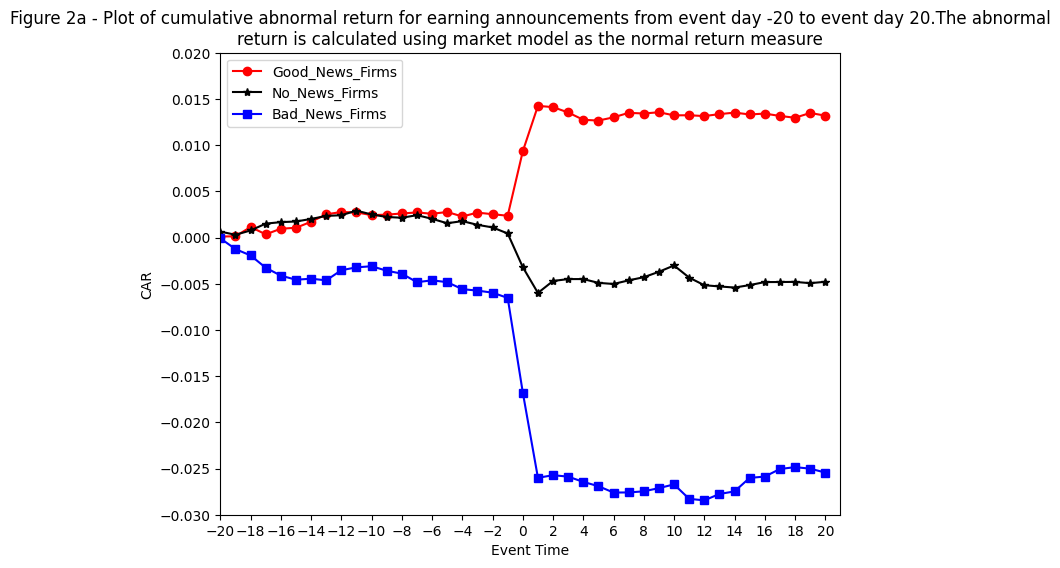

In [129]:
# Figure 2a
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(Table_1_Parta['Good_News_CAR'], color = "red", marker = 'o', label='Good_News_Firms')
ax.plot(Table_1_Parta['No_News_CAR'], color = "black", marker = '*', label='No_News_Firms')
ax.plot(Table_1_Parta['Bad_News_CAR'], color = "blue", marker = 's',label='Bad_News_Firms')
plt.xlim([-20, 21])
plt.ylim([-0.030, 0.020])
plt.xticks(np.arange(-20, 22, 2))
plt.yticks(np.arange(-0.030, 0.025, 0.005))
ax.set_title('\n'.join(wrap('Figure 2a - Plot of cumulative abnormal return for earning announcements from event day -20 to event day 20.The abnormal return is calculated using market model as the normal return measure',120)))
plt.xlabel("Event Time")
plt.ylabel("CAR")
plt.legend(loc = 'upper left')

##5.2 Based on Constant Mean Return Model

In [130]:
mean_return_data['abnormal_return'] = (mean_return_data['ret'] - mean_return_data['normal_return'])
mean_return_data['Event_day']= (mean_return_data['Event_day']).dt.days
mean_return_data

,date,ticker,cusip,ret,vwretd,meanest,actual,announcementDate,group_id,New_information,Event_day,check_event_window,intercept,normal_return,abnormal_return
0,2013-04-11,ADT,00101J10,-0.011840,0.003194,0.42,0.41,2013-05-01,1,No_News,-20,1,0.001731,0.001731,-0.013570
1,2013-04-12,ADT,00101J10,0.020191,-0.003765,0.42,0.41,2013-05-01,1,No_News,-19,1,0.001731,0.001731,0.018460
2,2013-04-15,ADT,00101J10,-0.042627,-0.025563,0.42,0.41,2013-05-01,1,No_News,-16,1,0.001731,0.001731,-0.044358
3,2013-04-16,ADT,00101J10,-0.014312,0.014659,0.42,0.41,2013-05-01,1,No_News,-15,1,0.001731,0.001731,-0.016043
4,2013-04-17,ADT,00101J10,0.012445,-0.014664,0.42,0.41,2013-05-01,1,No_News,-14,1,0.001731,0.001731,0.010714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102847,2014-12-17,AVGO,Y0486S10,0.020651,0.021779,1.68,1.99,2014-12-03,4426,Good_News,14,1,0.002157,0.002157,0.018494
102848,2014-12-18,AVGO,Y0486S10,0.026871,0.021536,1.68,1.99,2014-12-03,4426,Good_News,15,1,0.002157,0.002157,0.024714
102849,2014-12-19,AVGO,Y0486S10,-0.014757,0.004598,1.68,1.99,2014-12-03,4426,Good_News,16,1,0.002157,0.002157,-0.016913
102850,2014-12-22,AVGO,Y0486S10,0.012581,0.003256,1.68,1.99,2014-12-03,4426,Good_News,19,1,0.002157,0.002157,0.010424


In [131]:
Good_News_mean_data = mean_return_data[mean_return_data['New_information'] == 'Good_News']
AR_Good_News_mean_model = Good_News_mean_data.groupby('Event_day')['abnormal_return'].mean()
Sub_Table_2_1 = pd.DataFrame(AR_Good_News_mean_model)
Sub_Table_2_1 = Sub_Table_2_1.rename(columns={'abnormal_return': 'Good_News_AR'})
Sub_Table_2_1['Good_News_CAR'] = Sub_Table_2_1['Good_News_AR'].cumsum()
Sub_Table_2_1

,Good_News_AR,Good_News_CAR
Event_day,,
-20,0.000378,0.000378
-19,-0.000058,0.000321
-18,0.000303,0.000624
-17,-0.002589,-0.001966
-16,0.000208,-0.001758
-15,0.000198,-0.001559
-14,0.001179,-0.000380
-13,0.001463,0.001082
-12,0.000639,0.001722


In [132]:
No_News_mean_data = mean_return_data[mean_return_data['New_information'] == 'No_News']
AR_No_News_mean_model = No_News_mean_data.groupby('Event_day')['abnormal_return'].mean()
Sub_Table_2_2 = pd.DataFrame(AR_No_News_mean_model)
Sub_Table_2_2 = Sub_Table_2_2.rename(columns={'abnormal_return': 'No_News_AR'})
Sub_Table_2_2['No_News_CAR'] = Sub_Table_2_2['No_News_AR'].cumsum()
Sub_Table_2_2

,No_News_AR,No_News_CAR
Event_day,,
-20,0.001113,0.001113
-19,-0.000481,0.000631
-18,0.000081,0.000712
-17,-0.000748,-0.000036
-16,-0.000109,-0.000145
-15,0.000326,0.000181
-14,0.000578,0.000759
-13,0.000236,0.000994
-12,0.000666,0.001660


In [133]:
Bad_News_mean_data = mean_return_data[mean_return_data['New_information'] == 'Bad_News']
AR_Bad_News_mean_model = Bad_News_mean_data.groupby('Event_day')['abnormal_return'].mean()
Sub_Table_2_3 = pd.DataFrame(AR_Bad_News_mean_model)
Sub_Table_2_3 = Sub_Table_2_3.rename(columns={'abnormal_return': 'Bad_News_AR'})
Sub_Table_2_3['Bad_News_CAR'] = Sub_Table_2_3['Bad_News_AR'].cumsum()
Sub_Table_2_3

,Bad_News_AR,Bad_News_CAR
Event_day,,
-20,0.000501,0.000501
-19,-0.000612,-0.000111
-18,-0.001625,-0.001736
-17,-0.002350,-0.004085
-16,-0.001047,-0.005132
-15,-0.000511,-0.005644
-14,0.000911,-0.004732
-13,0.000365,-0.004367
-12,0.002054,-0.002313


In [134]:
Table_1_Partb = pd.concat([Sub_Table_2_1, Sub_Table_2_2,Sub_Table_2_3],axis=1,sort=False)#.applymap(lambda x :'%.2f%%'  %  (x*100))
Table_1_Partb

,Good_News_AR,Good_News_CAR,No_News_AR,No_News_CAR,Bad_News_AR,Bad_News_CAR
Event_day,,,,,,
-20,0.000378,0.000378,0.001113,0.001113,0.000501,0.000501
-19,-0.000058,0.000321,-0.000481,0.000631,-0.000612,-0.000111
-18,0.000303,0.000624,0.000081,0.000712,-0.001625,-0.001736
-17,-0.002589,-0.001966,-0.000748,-0.000036,-0.002350,-0.004085
-16,0.000208,-0.001758,-0.000109,-0.000145,-0.001047,-0.005132
-15,0.000198,-0.001559,0.000326,0.000181,-0.000511,-0.005644
-14,0.001179,-0.000380,0.000578,0.000759,0.000911,-0.004732
-13,0.001463,0.001082,0.000236,0.000994,0.000365,-0.004367
-12,0.000639,0.001722,0.000666,0.001660,0.002054,-0.002313


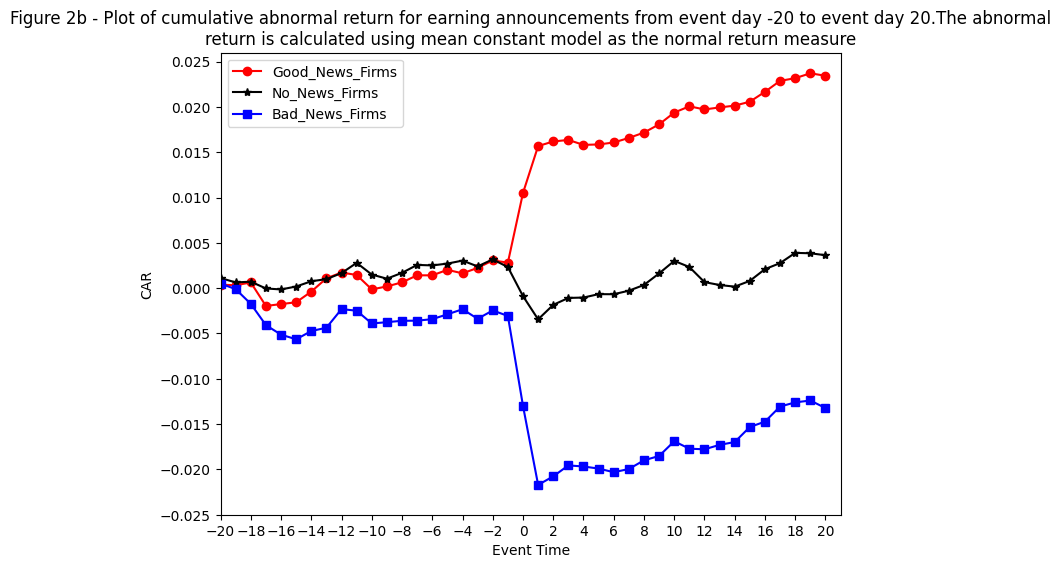

In [135]:
# Figure 2b
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(Table_1_Partb['Good_News_CAR'], color = "red", marker = 'o', label='Good_News_Firms')
ax.plot(Table_1_Partb['No_News_CAR'], color = "black", marker = '*', label='No_News_Firms')
ax.plot(Table_1_Partb['Bad_News_CAR'], color = "blue", marker = 's', label='Bad_News_Firms')
plt.xlim([-20, 21])
plt.xticks(np.arange(-20, 22, 2))
plt.yticks(np.arange(-0.025, 0.030, 0.005))
ax.set_title('\n'.join(wrap('Figure 2b - Plot of cumulative abnormal return for earning announcements from event day -20 to event day 20.The abnormal return is calculated using mean constant model as the normal return measure',120)))
plt.xlabel("Event Time")
plt.ylabel("CAR")
plt.legend(loc = 'upper left')

##5.3 Hypothesis Test

In [136]:
# Calculte variance and theta to test the hypothesis of two model.
Std_AR_Good_News_market_model = AR_Good_News_market_model.std()
Theta_AR_Good_News_market_model = Sub_Table_1_1.Good_News_CAR.iloc[40]/Std_AR_Good_News_market_model
Std_AR_No_News_market_model = AR_No_News_market_model.std()
Theta_CAR_No_News_market_model = Sub_Table_1_2.No_News_CAR.iloc[40]/Std_AR_No_News_market_model
Std_AR_Bad_News_market_model = AR_Bad_News_market_model.std()
Theta_CAR_Bad_News_market_model = Sub_Table_1_3.Bad_News_CAR.iloc[40]/Std_AR_Bad_News_market_model

In [137]:
Market_model_hypothesis_test = {'Good_News':pd.Series([Std_AR_Good_News_market_model,Theta_AR_Good_News_market_model],index=['Variance','Theta']),
         'No_News':pd.Series([Std_AR_No_News_market_model,Theta_CAR_No_News_market_model],index=['Variance','Theta']),
         'Bad_News':pd.Series([Std_AR_Bad_News_market_model,Theta_CAR_Bad_News_market_model],index=['Variance','Theta'])}
Market_model_hypothesis_test = pd.DataFrame(Market_model_hypothesis_test)
Market_model_hypothesis_test

,Good_News,No_News,Bad_News
Variance,0.001365,0.000857,0.002179
Theta,9.666980,-5.592608,-11.673653


In [138]:
Std_AR_Good_News_mean_model = AR_Good_News_mean_model.std()
Theta_AR_Good_News_mean_model = Sub_Table_2_1.Good_News_CAR.iloc[40]/Std_AR_Good_News_mean_model
Std_AR_No_News_mean_model = AR_No_News_mean_model.std()
Theta_CAR_No_News_mean_model =Sub_Table_2_2.No_News_CAR.iloc[40]/Std_AR_No_News_mean_model
Std_AR_Bad_News_mean_model = AR_Bad_News_mean_model.std()
Theta_CAR_Bad_News_mean_model = Sub_Table_2_3.Bad_News_CAR.iloc[40]/Std_AR_Bad_News_mean_model

In [139]:
Mean_model_hypothesis_test = {'Good_News':pd.Series([Std_AR_Good_News_mean_model,Theta_AR_Good_News_mean_model],index=['Variance','Theta']),
         'No_News':pd.Series([Std_AR_No_News_mean_model,Theta_CAR_No_News_mean_model],index=['Variance','Theta']),
         'Bad_News':pd.Series([Std_AR_Bad_News_mean_model,Theta_CAR_Bad_News_mean_model],index=['Variance','Theta'])}
Mean_model_hypothesis_test = pd.DataFrame(Mean_model_hypothesis_test)
Mean_model_hypothesis_test

,Good_News,No_News,Bad_News
Variance,0.001551,0.001004,0.002263
Theta,15.107839,3.619374,-5.845542
